### Importing Libraries

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')

### Loading Dataset and Data Preprocessing

In [ ]:
df = pd.read_csv("/content/fct_order.csv")
df

order_id      order_time  vendor_id    analytical_customer_id  \
0       544145594  9/1/2021 10:41     609508  6zWSp9yqnEQuq4N6ykRgbbdQ   
1       544478492  9/1/2021 18:17     602440  TtmFFw26sQR26nBE2RykhxQA   
2       544358032  9/1/2021 15:56     709071  7pB4MC2aBPRdajLH2wPvIvAA   
3       544366924  9/1/2021 16:09     607670  AFedsf0e-lSZer_X0eR4VE-g   
4       544372362  9/1/2021 16:16     616421  JDYqF36aULSEaWsz604DuuRw   
...           ...             ...        ...                       ...   
119880  642783788   1/1/2022 9:50     604427  _B1YUyVOo-RLOoFMVCiTi-DQ   
119881  642718374   1/1/2022 3:24     607605  yTrHLDAuhuScuiCHABzNUdWA   
119882  642739962   1/1/2022 6:58     603674  jWIm4qj6vORl6B1ejy0EImDQ   
119883  643440356  1/1/2022 23:00     602778  RiSAcy9SUKT5SU_k9rWqVeug   
119884  643105834  1/1/2022 17:01     602795  3zGv03US8BT-SpBHUAKVWmDQ   

        is_acquisition  is_successful reason sub_reason owner  \
0                False           True    NaN        NaN   NaN   
1                False           True    NaN        NaN   NaN   
2                False           True    NaN        NaN   NaN   
3                False           True    NaN        NaN   NaN   
4                False           True    NaN        NaN   NaN   
...                ...            ...    ...        ...   ...   
119880            True           True    NaN        NaN   NaN   
119881           False           True    NaN        NaN   NaN   
119882           False           True    NaN        NaN   NaN   
119883           False           True    NaN        NaN   NaN   
119884            True           True    NaN        NaN   NaN   

       delivery_arrangement  ...  is_affordable_freedelivery  \
0                       TGO  ...                       False   
1                       TGO  ...                       False   
2                       TGO  ...                       False   
3                       TGO  ...                       False   
4                       TGO  ...                       False   
...                     ...  ...                         ...   
119880                  TMP  ...                       False   
119881                  TMP  ...                       False   
119882                  TMP  ...                       False   
119883                  TMP  ...                       False   
119884                  TMP  ...                       False   

        is_affordable_item  is_affordable_gem is_affordable_restaurant  \
0                    False              False                    False   
1                    False              False                    False   
2                    False              False                    False   
3                    False              False                    False   
4                    False              False                    False   
...                    ...                ...                      ...   
119880               False              False                    False   
119881               False              False                    False   
119882               False              False                    False   
119883               False              False                    False   
119884               False              False                    False   

        is_affordable_voucher  is_affordable  affordability_amt_total  \
0                       False          False                      NaN   
1                       False          False                      NaN   
2                       False          False                      NaN   
3                       False          False                      NaN   
4                       False          False                      NaN   
...                       ...            ...                      ...   
119880                  False          False                      NaN   
119881                  False          False                      NaN   
119882                  

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119885 entries, 0 to 119884
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   order_id                    119885 non-null  int64  
 1   order_time                  119885 non-null  object 
 2   vendor_id                   119885 non-null  int64  
 3   analytical_customer_id      119885 non-null  object 
 4   is_acquisition              119885 non-null  bool   
 5   is_successful               119885 non-null  bool   
 6   reason                      19716 non-null   object 
 7   sub_reason                  8348 non-null    object 
 8   owner                       19716 non-null   object 
 9   delivery_arrangement        119885 non-null  object 
 10  gmv_amount_lc               119885 non-null  float64
 11  basket_amount_lc            119885 non-null  float64
 12  delivery_fee_amount_lc      119885 non-null  float64
 13  Payment Method

In [ ]:
df['order_time'] = pd.to_datetime(df['order_time'])

In [ ]:
#Creating a new table for the daily orders, in order to formulate the problem as a univariate time series case
df['order_date'] = df['order_time'].dt.date

daily_orders_df = df.groupby('order_date').size().reset_index(name='daily_orders')

In [ ]:
daily_orders_df

order_date  daily_orders
0    2021-09-01           972
1    2021-09-02          1016
2    2021-09-03           998
3    2021-09-04          1033
4    2021-09-05          1003
..          ...           ...
119  2021-12-29           973
120  2021-12-30           974
121  2021-12-31          1081
122  2022-01-01           930
123  2022-01-02           929

[124 rows x 2 columns]

In [ ]:
daily_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   order_date    124 non-null    object
 1   daily_orders  124 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [ ]:
#setting Date to be the index of the dataframe
daily_orders_df = daily_orders_df.set_index("order_date")

In [ ]:
daily_orders_df

daily_orders
order_date              
2021-09-01           972
2021-09-02          1016
2021-09-03           998
2021-09-04          1033
2021-09-05          1003
...                  ...
2021-12-29           973
2021-12-30           974
2021-12-31          1081
2022-01-01           930
2022-01-02           929

[124 rows x 1 columns]

In [ ]:
#retrieving some statistical information about dataset features
daily_orders_df.describe()

daily_orders
count    124.000000
mean     966.814516
std       61.724192
min      808.000000
25%      924.750000
50%      973.000000
75%     1013.000000
max     1084.000000

In [ ]:
daily_orders_df = daily_orders_df.sort_index()
daily_orders_df

daily_orders
order_date              
2021-09-01           972
2021-09-02          1016
2021-09-03           998
2021-09-04          1033
2021-09-05          1003
...                  ...
2021-12-29           973
2021-12-30           974
2021-12-31          1081
2022-01-01           930
2022-01-02           929

[124 rows x 1 columns]

In [ ]:
fig1 = px.line(daily_orders_df, y='daily_orders', template='plotly_dark')
fig1.update_layout(title_text='The Number of Daily Orders', title_x=0.5)
fig1.show()

In [ ]:
#splitting data into train and test
train_data = daily_orders_df[:114]
test_data = daily_orders_df[114:]

In [ ]:
train_data

daily_orders
order_date              
2021-09-01           972
2021-09-02          1016
2021-09-03           998
2021-09-04          1033
2021-09-05          1003
...                  ...
2021-12-19           837
2021-12-20           925
2021-12-21           864
2021-12-22           960
2021-12-23           930

[114 rows x 1 columns]

In [ ]:
test_data

daily_orders
order_date              
2021-12-24          1000
2021-12-25           979
2021-12-26           976
2021-12-27           885
2021-12-28           937
2021-12-29           973
2021-12-30           974
2021-12-31          1081
2022-01-01           930
2022-01-02           929

### ARIMA Model

In [ ]:
ARIMA_model = pm.auto_arima(train_data["daily_orders"],
                      start_p=1,
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

In [ ]:
ARIMA_model

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True)

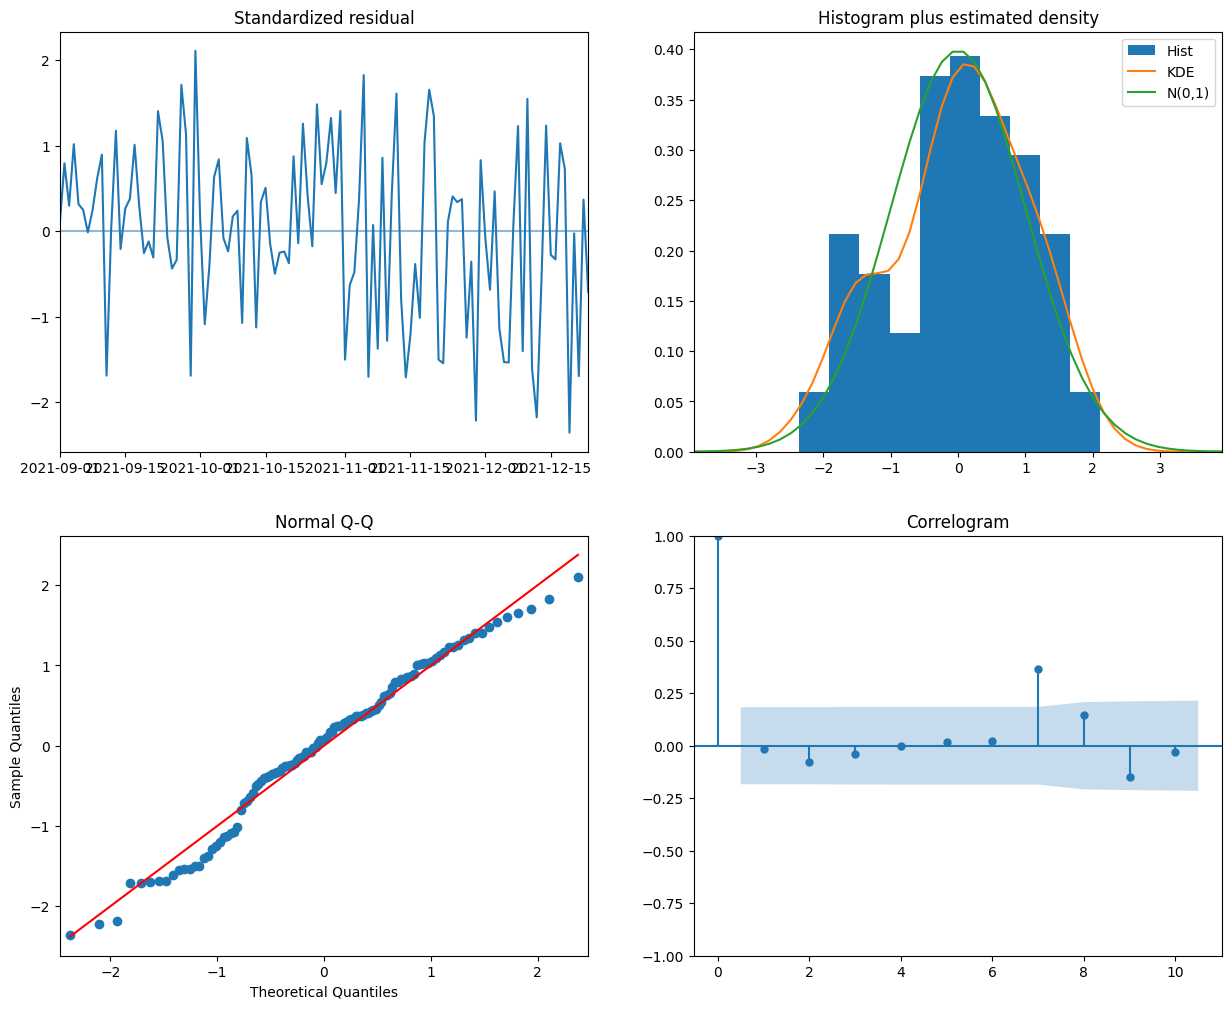

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
mod = sm.tsa.arima.ARIMA(train_data["daily_orders"], order=(0,0,1))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:           daily_orders   No. Observations:                  114
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -629.143
Date:                Wed, 13 Sep 2023   AIC                           1264.287
Time:                        01:44:10   BIC                           1272.495
Sample:                    09-01-2021   HQIC                          1267.618
                         - 12-23-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        966.8117      7.465    129.511      0.000     952.180     981.443
ma.L1          0.2823      0.084      3.354      0.001       0.117       0.447
sigma2      3637.1242    589.222      6.173      0.0

In [ ]:
pred0 = res.get_prediction(start='2021-09-01', dynamic=False)
pred0_ci = pred0.conf_int()

In [ ]:
#plotting train data against train predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data.index, y=train_data["daily_orders"],
                    mode='lines',
                    name='Daily Orders'))
fig.add_trace(go.Scatter(x=train_data.index, y=pred0.predicted_mean,
                    mode='lines',
                    name='ARIMA Model Fit'))

fig.update_layout(title_text='ARIMA Model Fit Against Training Data', title_x=0.5, template='plotly_dark')

fig.show()

In [ ]:
pred2 = res.get_forecast(steps=10)
pred2_ci = pred2.conf_int()

In [ ]:
#plotting train data against train predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_data.index, y=test_data["daily_orders"],
                    mode='lines',
                    name='Daily Orders'))
fig.add_trace(go.Scatter(x=test_data.index, y=pred2.predicted_mean,
                    mode='lines',
                    name='ARIMA Model Predictions'))

fig.update_layout(title_text='ARIMA Model Predictions Against Test Data', title_x=0.5, template='plotly_dark')

fig.show()

### Calculating Model Accuracy on Test Data

In [ ]:
RMSE = np.sqrt(np.mean((np.asarray(test_data['daily_orders']) - np.asarray(pred2.predicted_mean)))**2)
print(RMSE)

0.8032635907755207


### Forecasting Daily Orders of January and February

In [ ]:
forecast_dates = pd.date_range('2022-01-01', periods=59, freq='1d')
print(forecast_dates)
print(len(forecast_dates))

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
               '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20',
               '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
               '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
               '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
               '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05',
               '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09',
               '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13',
               '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
               '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21',
               '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
      

In [ ]:
forecasting = res.get_forecast(steps=69)
forecasting_ci = forecasting.conf_int()

In [ ]:
fig1 = px.line(x=forecast_dates, y=forecasting.predicted_mean[10:], template='plotly_dark')
fig1.update_layout(title_text='Forecasting The Number of Daily Orders During January and February', title_x=0.5)
fig1.show()